In [56]:
#jax bisher nur für CPU intslliert (pip install -U "jax[cpu]")
import jax.numpy as jnp
import jax.lax as lax
from jax import jit, vmap
from functools import partial
from matplotlib import pyplot as plt
from scipy import constants as const
import timeit

# Plot-Formatierung
plt.rcParams['font.size'] = 24.0
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['lines.linewidth'] = 2.0

G = const.G / (3.0857E+16)**3 * 1.989E+30 * (3.0857E+13)**2 #impurity ist ok (G ist konstant über die Auswertung)
                            #Umrechnung in pc^3/M_sun/s^2 (grav pot in (km/s)^2)
                            #Umrechnung, sodass z in parsec

#Formulierung des Anfangswertproblems (z taucht in den Formeln auf, um an anderen DGLs zu testen)
f = lambda roh_dm, params, z, u: jnp.array([u[1], \
            4*jnp.pi*G * (jnp.sum(params[:,0]*jnp.exp(-u[0]/params[:,1]**2)) + roh_dm)])
z0 = 0.
u0 = jnp.array([0.,0.]) #freie Nullpunktswahl/Symmetrie
roh_dm = 0.025 #M_sun/pc^3
params = jnp.array([[0.021, 4.], [0.016, 7.], [0.012, 9.], \
                    [0.0009, 40.], [0.0006, 20.], [0.0031, 7.5], \
                    [0.0015, 10.5], [0.0020, 14.], [0.0022, 18.], \
                    [0.007, 18.5], [0.0135, 18.5], [0.006, 20.], \
                    [0.002, 20.], [0.0035, 37.], [0.0001, 100.]]) 
                                                        #mu(0) ??? in M_sun/pc^3, sigma(0) in km/s

In [57]:
#Routinen

# jit(step)
@partial(jit, static_argnames=['f', 'n'])
def eigenerSolverV1(roh_dm, params, z0, u0, f, n, dz):
                                                          
    # Runge-Kutta 4. Ordnung
    @partial(jit, static_argnames=['f']) #nötig ??
    def rk4_step(roh_dm, params, z0, u0, dz, f):
        k1 = dz * f(roh_dm, params, z0, u0)
        k2 = dz * f(roh_dm, params, z0 + dz / 2, u0 + k1 / 2)
        k3 = dz * f(roh_dm, params, z0 + dz / 2, u0 + k2 / 2)
        k4 = dz * f(roh_dm, params, z0 + dz, u0 + k3)
        u1 = u0 + (k1 + 2 * k2 + 2 * k3 + k4) / 6
        return u1
    
    uz = []

    for i in range(n):
        u0 = rk4_step(roh_dm, params, z0+i*dz, u0, dz, f)
        uz.append(u0)

    return uz

# lax.scan(step)
@partial(jit, static_argnames=['f', 'n']) 
def eigenerSolverV2(roh_dm, params, z0, u0, f, n, dz):
                                                          
    # Runge-Kutta 4. Ordnung
    @partial(jit, static_argnames=['f']) #nötig ??
    def rk4_step(roh_dm, params, z0, u0, dz, f):
        k1 = dz * f(roh_dm, params, z0, u0)
        k2 = dz * f(roh_dm, params, z0 + dz / 2, u0 + k1 / 2)
        k3 = dz * f(roh_dm, params, z0 + dz / 2, u0 + k2 / 2)
        k4 = dz * f(roh_dm, params, z0 + dz, u0 + k3)
        u1 = u0 + (k1 + 2 * k2 + 2 * k3 + k4) / 6
        return u1

    def rk4_step_scan(u, i):
        return rk4_step(roh_dm, params, z0+i*dz, u, dz, f), \
            rk4_step(roh_dm, params, z0+i*dz, u, dz, f)

    _, uz = lax.scan(rk4_step_scan, u0, jnp.linspace(0, n*dz, n))

    return uz

# neu mit diffrax
from diffrax import diffeqsolve, Dopri5, Tsit5, Dopri8, ODETerm, SaveAt, PIDController

# Dopri5
@partial(jit, static_argnames=['f', 'n']) 
def diffraxDopri5(roh_dm, params, z0, u0, f, n, dz):

    vector_field = lambda z, y, args: f(args[0], args[1], z, y) #wrapper für reihenfolge
    term = ODETerm(vector_field)
    solver = Dopri5()
    saveat = SaveAt(ts=jnp.linspace(0, n*dz, n))
    stepsize_controller = PIDController(rtol=1e-5, atol=1e-5)

    sol = diffeqsolve(term, solver, t0=z0, t1=z0+n*dz, dt0=dz, y0=u0,
                        args=(roh_dm, params),
                    saveat=saveat,
                    stepsize_controller=stepsize_controller)

    zs = sol.ts
    uz = sol.ys

    return uz

# Tsit5
@partial(jit, static_argnames=['f', 'n']) 
def diffraxTsit5(roh_dm, params, z0, u0, f, n, dz):

    vector_field = lambda z, y, args: f(args[0], args[1], z, y) #wrapper für reihenfolge
    term = ODETerm(vector_field)
    solver = Tsit5()
    saveat = SaveAt(ts=jnp.linspace(0, n*dz, n))
    stepsize_controller = PIDController(rtol=1e-5, atol=1e-5)

    sol = diffeqsolve(term, solver, t0=z0, t1=z0+n*dz, dt0=dz, y0=u0,
                        args=(roh_dm, params),
                    saveat=saveat,
                    stepsize_controller=stepsize_controller)

    zs = sol.ts
    uz = sol.ys

    return uz

# Dopri8
@partial(jit, static_argnames=['f', 'n']) 
def diffraxDopri8(roh_dm, params, z0, u0, f, n, dz):

    vector_field = lambda z, y, args: f(args[0], args[1], z, y) #wrapper für reihenfolge
    term = ODETerm(vector_field)
    solver = Dopri8()
    saveat = SaveAt(ts=jnp.linspace(0, n*dz, n))
    stepsize_controller = PIDController(rtol=1e-5, atol=1e-5)

    sol = diffeqsolve(term, solver, t0=z0, t1=z0+n*dz, dt0=dz, y0=u0,
                        args=(roh_dm, params),
                    saveat=saveat,
                    stepsize_controller=stepsize_controller)

    zs = sol.ts
    uz = sol.ys

    return uz

In [58]:
# Benchmark

n = 1200
dz = 1.

In [59]:
# print('eigener Solver V1:')
# %timeit uz = eigenerSolverV1(roh_dm, params, z0, u0, f, n, dz)

In [60]:
print('eigener Solver V2:')
%time uz = eigenerSolverV2(roh_dm, params, z0, u0, f, n, dz).block_until_ready()
%timeit eigenerSolverV2(roh_dm, params, z0, u0, f, n, dz).block_until_ready()

eigener Solver V2:
CPU times: total: 31.2 ms
Wall time: 84.1 ms
196 µs ± 2.66 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [61]:
print('diffrax Dopri5:')
%time uz = diffraxDopri5(roh_dm, params, z0, u0, f, n , dz).block_until_ready()
%timeit diffraxDopri5(roh_dm, params, z0, u0, f, n , dz).block_until_ready()


diffrax Dopri5:
CPU times: total: 234 ms
Wall time: 353 ms
187 µs ± 3.15 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [62]:

print('diffrax Tsit5:')
%time uz = diffraxTsit5(roh_dm, params, z0, u0, f, n , dz).block_until_ready()
%timeit diffraxTsit5(roh_dm, params, z0, u0, f, n , dz).block_until_ready()

diffrax Tsit5:
CPU times: total: 172 ms
Wall time: 390 ms
201 µs ± 3.98 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [63]:

print('diffrax Dopri8:')
%time uz = diffraxDopri8(roh_dm, params, z0, u0, f, n , dz).block_until_ready()
%timeit diffraxDopri8(roh_dm, params, z0, u0, f, n , dz).block_until_ready()

diffrax Dopri8:
CPU times: total: 203 ms
Wall time: 359 ms
222 µs ± 6.76 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


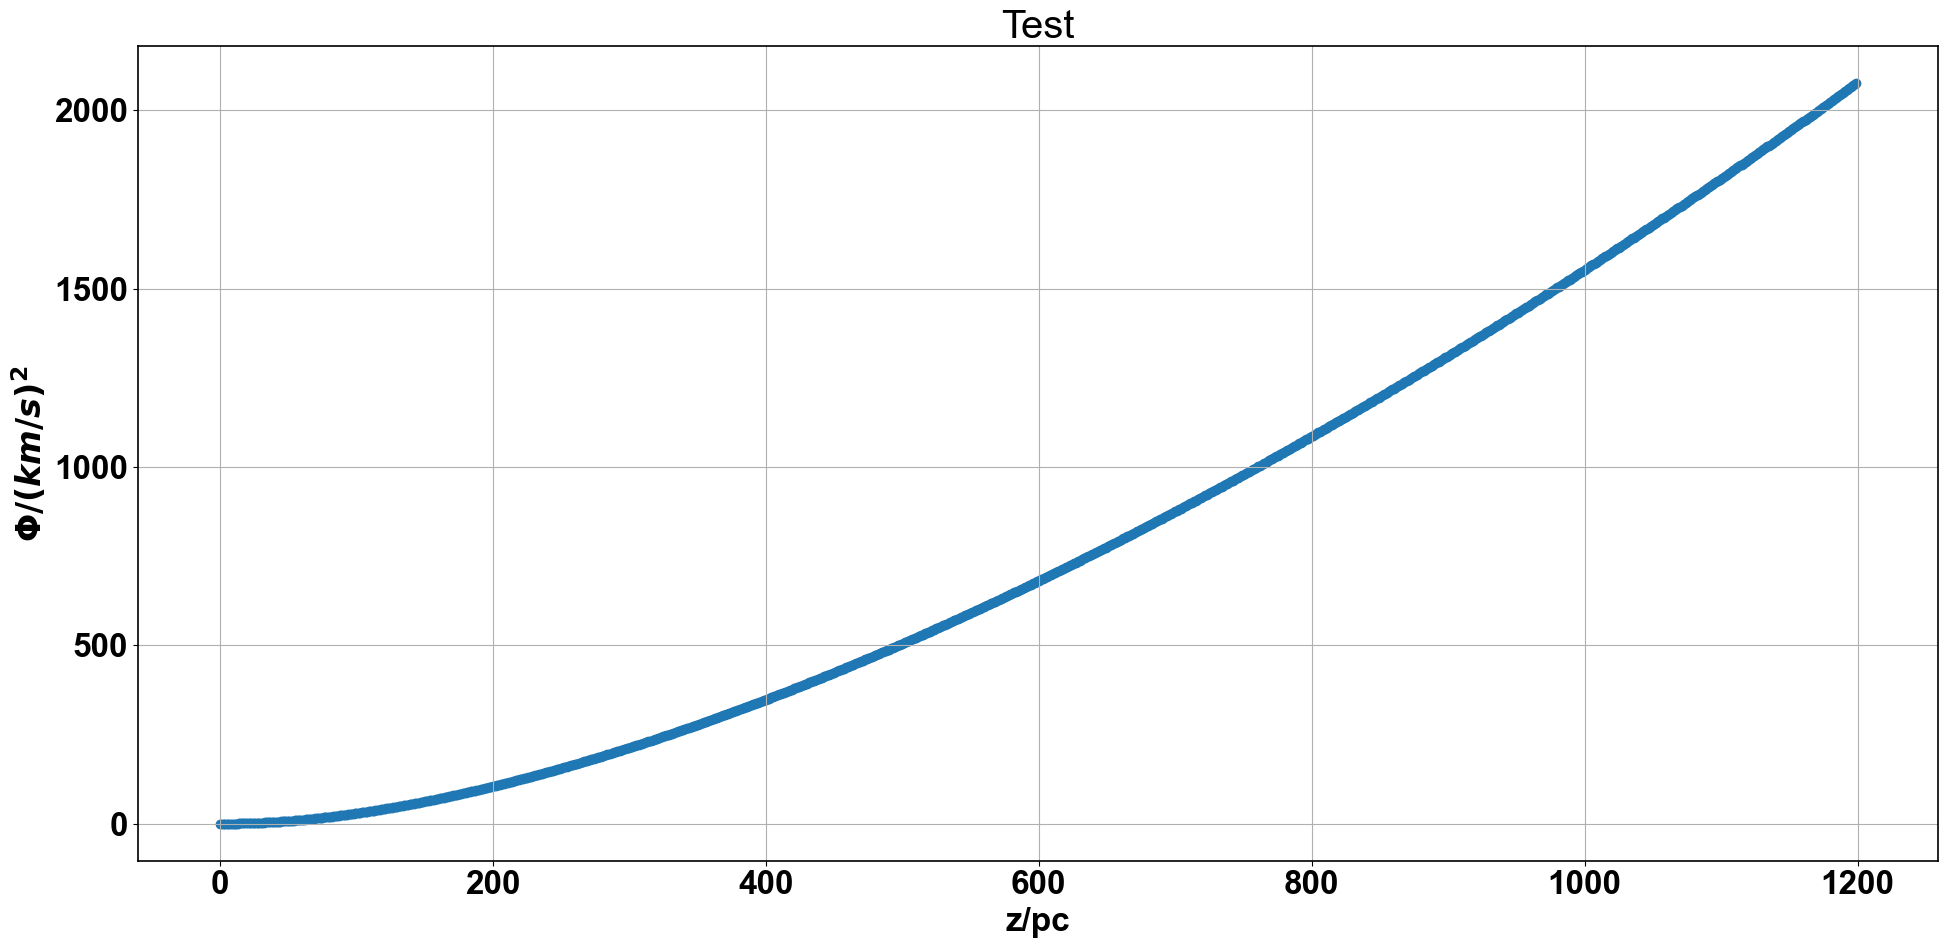

In [64]:
# Plot
fig, ax1 = plt.subplots(figsize=(20,10))
plt.title('Test')
ax1.set_xlabel('z/pc')
ax1.set_ylabel('$\Phi / (km/s)^2$')
ax1.scatter([z0+i*dz for i in range(n)], [u[0] for u in uz], marker='o')
ax1.grid()
fig.tight_layout()